<a href="https://colab.research.google.com/github/motokikando/bayes_modeling/blob/master/multiple_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
#必要なモジュールのインポート
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan 
import seaborn as sns

%matplotlib inline

In [4]:
#スタイルの指定
plt.style.use("ggplot")

In [5]:
file_path = '/content/drive/My Drive/ベイズ統計学/pystan_data/real_estate2.xlsx'
df = pd.read_excel(file_path)

In [6]:
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


In [13]:
#データの前処理を行う
#築年数(経過年数)elapsed を2018 - df["year"]で算出する
df["elapsed"] = 2018 - df["year"]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [21]:
#distanceの要素の種類を取得する df[""].unique()
df["distance"].unique()


array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [22]:
#dis_arrに格納
dis_arr = df["distance"].unique()

In [26]:
#辞書型でそれぞれのdis_dictに数値をvalueとして付与 '-'はnp.nanで対応
dis_dict = {dis_arr[0]:10, dis_arr[1]:15, dis_arr[2]:5, dis_arr[3]:20, dis_arr[4]: 30, dis_arr[5]:np.nan}

#新しくdf["distance2"]を作成  distanceに対して.apply (lambda 引数:　dis_dict値の取り出し)
df["distance2"] = df["distance"].apply(lambda x: dis_dict[x])

In [27]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,35,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,35,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,35,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0


In [28]:
#naに関しては除去を行う
df = df.dropna()

In [29]:
#df2に重回帰分析で使用する　変数 space, elapsed. distance2, valueだけをdf[["", ""]]で格納
df2 = df[["space", "elapsed", "distance2", "value"]]

In [30]:
df2.head()

,space,elapsed,distance2,value
0,70,35,10.0,910
1,70,35,10.0,1120
2,70,35,10.0,1190
3,70,35,10.0,1190
4,70,35,10.0,1190


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


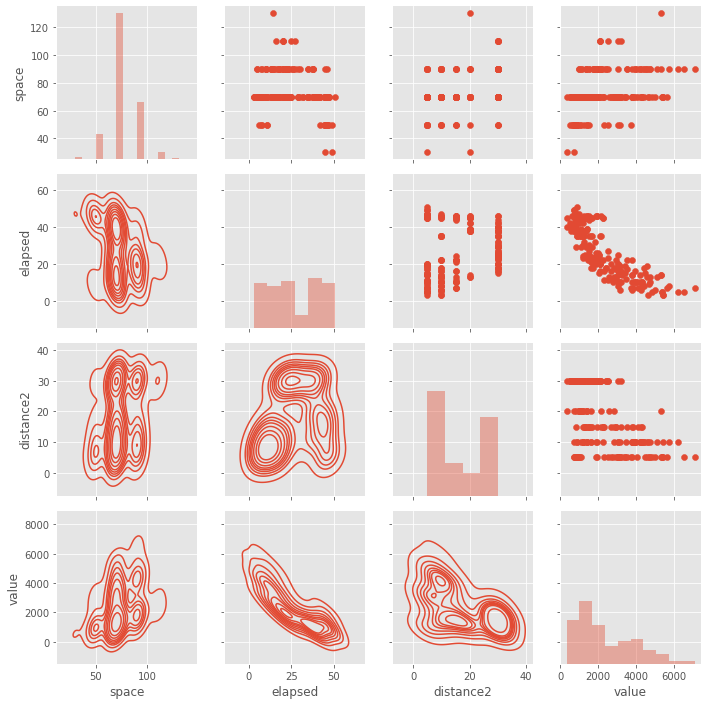

In [37]:
#各columnごとの関係を可視化
g = sns.PairGrid(df2) #各パラメータごとに関係について作成
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(plt.scatter)

In [40]:
#stanモデル記述
stan_model = """
#　dataの定義
data { 
    int N;  #物件数 N
    real elapsed[N]; #経過年数
    real dis[N];#距離 
    real space[N]; #部屋の広さ
    real Y[N]; #予測をする物件の価格
    }
parameters {
  real d;
  real s;
  real e;
  real b;
  real <lower=0> sigma;
}
model {
  real mu;
  for (n in 1:N){
    mu = e * elapsed[n] + d * dis[n] + s * space[n] + b;
    Y[n] ~ normal(mu, sigma); #Y[n]は正規分布， mu, sigmaに従う
  }
}

"""

In [41]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_620499850d88b1ba9dc139aa07f13854 NOW.


In [43]:
#データの定義
stan_data = {"N":df.shape[0], "elapsed":df["elapsed"], "dis":df["distance2"], "space":df["space"], "Y":df["value"]}

In [44]:
#MCサンプリング
fit = sm.sampling(data = stan_data, iter = 2000, chains=4, seed=123)

In [45]:
fit

Inference for Stan model: anon_model_620499850d88b1ba9dc139aa07f13854.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d     -57.54     0.1   5.04 -67.52 -61.04  -57.5  -54.1  -47.6   2406    1.0
s      24.57     0.1   3.64  17.28  22.21  24.67  27.04  31.63   1248   1.01
e     -67.68    0.09   3.82 -75.01  -70.3 -67.66 -65.14 -60.19   1766    1.0
b     3301.8    8.43 301.16 2729.4 3087.5 3303.6 3502.8 3901.2   1277    1.0
sigma 638.11    0.58  33.01 576.51 615.02 636.31  659.8 708.36   3204    1.0
lp__   -1363    0.04   1.62  -1367  -1364  -1363  -1362  -1361   1543    1.0

Samples were drawn using NUTS at Wed Jan 19 03:16:53 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

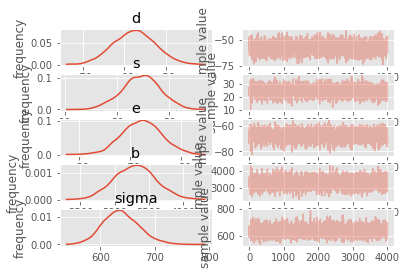

In [47]:
fig = fit.plot()